In [1]:
import glob, os, re, pickle
import pandas as pd
import numpy as np
from Paths import *
from OtherUsefulFunctions import *
from ClassificationFunctions import *

In [2]:
args = parse_args()
train_list, test_list = load_lists(args, reCreate=False)

Loading data list from pickle files
######################################################################################
Dataset Statistics
Train and test lists done, sizes :  6000 & 800 & 900
Test size [%] :  11.7
Validation size [%] :  10.4
Class  0 :     Train  1697  Test  191  [%]   9.1  Validation  215  [%]  10.2
Class  1 :     Train  1651  Test  243  [%]  11.6  Validation  201  [%]  9.6
Class  2 :     Train  1653  Test  262  [%]  12.4  Validation  204  [%]  9.6
Class  3 :     Train   999  Test  204  [%]  14.8  Validation  180  [%]  13.0
######################################################################################


In [3]:
list_tfrecord_train, noise_train,maxT_train,fs_train = create_tfrecords_classADD(train_list, args, name=str(1)+'train',reCreate=False)
list_tfrecord_test, noise_test,maxT_test,fs_test = create_tfrecords_classADD(test_list, args, name=str(1)+'test',reCreate=False)
# If you set reCreate to True but do not have the original files from the list available  
# (samples only given in the github), the code will give a MatlabExecutionError

The 69 .tfrecord you are about to produce already exist, probably for the same list.
Re-run and change name if you do not want to overwrite them. If you do, set reCreate to True
The 10 .tfrecord you are about to produce already exist, probably for the same list.
Re-run and change name if you do not want to overwrite them. If you do, set reCreate to True


In [3]:
list_tfrecord_test, noise_test,maxT_test,fs_test = create_tfrecords_classADD(test_list, args, name=str(1)+'test',reCreate=False)

The 10 .tfrecord you are about to produce already exist, probably for the same list.
Re-run and change name if you do not want to overwrite them. If you do, set reCreate to True


In [4]:
train_dataset = input_pipeline(list_tfrecord_train[:36]+list_tfrecord_train[44:-1], args)
validation_dataset = input_pipeline(list_tfrecord_train[36:44], args) 

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [4]:
args.model_number=4

In [5]:
if os.path.exists(pathBase + '2_Classification/class_model/model'+str(args.model_number)+'.pickle'):
    with open(pathBase + '2_Classification/class_model/model'+str(args.model_number)+'.pickle', "rb") as f:
        loss_save,accuracy_save,precision,recall,auc,Vloss_save,Vaccuracy_save,Vprecision,Vrecall,Vauc = pickle.load(f)
else:
    loss_save=[]; accuracy_save=[];precision=[];recall=[];auc=[];
    Vloss_save=[]; Vaccuracy_save=[];Vprecision=[];Vrecall=[];Vauc=[];

In [6]:
ACCURACY_THRESHOLD = 0.98

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        loss_save.append(logs.get('loss'))
        accuracy_save.append(logs.get('accuracy'))
        precision.append(logs.get('precision'));recall.append(logs.get('recall'));auc.append(logs.get('auc'))
        Vloss_save.append(logs.get('val_loss'))
        Vaccuracy_save.append(logs.get('val_accuracy'))
        Vprecision.append(logs.get('val_precision'));Vrecall.append(logs.get('val_recall'));Vauc.append(logs.get('val_auc'))
                
        with open(pathBase + '2_Classification/class_model/model'+str(args.model_number)+'.pickle', "wb") as f:
            pickle.dump([loss_save,accuracy_save,precision,recall,auc,Vloss_save,Vaccuracy_save,Vprecision,Vrecall,Vauc], f)
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
            
metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

In [7]:
if args.model_number == 3: model = ConvModel3(NUMBER_OF_CLASSES)
if args.model_number == 4: model = ConvModel4(NUMBER_OF_CLASSES)
if args.model_number == 5: model = ConvModel5(NUMBER_OF_CLASSES)
if args.verbose: model.summary()
    
if args.verbose: print('loading weights of model', args.model_number)
if args.model_number == 3: model.load_weights(pathBase + '2_Classification/class_model/'+str(args.model_number)+'all/ckp45').expect_partial()
if args.model_number == 4: model.load_weights(pathBase + '2_Classification/class_model/'+str(args.model_number)+'all/ckp58').expect_partial()
if args.model_number == 5: model.load_weights(pathBase + '2_Classification/class_model/'+str(args.model_number)+'all/ckp41').expect_partial()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics= metrics)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Spectrogram (InputLayer)        [(None, 600, 544, 1) 0                                            
__________________________________________________________________________________________________
Norm.Frequency (BatchNormalizat (None, 600, 544, 1)  2400        Spectrogram[0][0]                
__________________________________________________________________________________________________
Layer1 (Conv2D)                 (None, 600, 544, 16) 28816       Norm.Frequency[0][0]             
__________________________________________________________________________________________________
Layer2 (AveragePooling2D)       (None, 300, 1, 16)   0           Layer1[0][

In [ ]:
MODEL 3

In [ ]:
if not args.skip_train:
    steps_per_epoch = int((len(list_tfrecord_train[:36])+len(list_tfrecord_train[44:-1]))*args.load_size/args.batch_size)
    validation_steps = int(len(list_tfrecord_train[36:44])*args.load_size/args.batch_size)
    model.fit(x=train_dataset[0],y=train_dataset[1],
              epochs=args.epochs,steps_per_epoch=steps_per_epoch, 
              validation_data=(validation_dataset[0],validation_dataset[1]), 
              validation_steps=validation_steps,
              callbacks=[myCallback(), es,
                         ModelCheckpoint(pathBase + '2_Classification/class_model/'+str(args.model_number)+'all/ckp'+"{epoch:02d}",
                                                   monitor='loss', verbose=1, save_best_only=False,mode='min',
                                                   save_weights_only=True)])
              #class_weight = {0:1,1:1,2:1,3:3})
    model.save(pathBase + 'class_model/model'+str(args.model_number))

Epoch 1/100
119/120 [============================>.] - ETA: 1s - loss: 1.9068 - accuracy: 0.4449 - precision: 0.5266 - recall: 0.1030 - auc: 0.6789
Epoch 00001: saving model to /scratch/maelle/class_model/3all/ckp01
120/120 [==============================] - 177s 1s/step - loss: 1.9014 - accuracy: 0.4445 - precision: 0.5261 - recall: 0.1040 - auc: 0.6796 - val_loss: 1.0678 - val_accuracy: 0.5375 - val_precision: 0.7083 - val_recall: 0.2975 - val_auc: 0.8018
Epoch 2/100
119/120 [============================>.] - ETA: 1s - loss: 0.9973 - accuracy: 0.6783 - precision: 0.7018 - recall: 0.3066 - auc: 0.8401
Epoch 00002: saving model to /scratch/maelle/class_model/3all/ckp02
120/120 [==============================] - 132s 1s/step - loss: 0.9991 - accuracy: 0.6775 - precision: 0.7001 - recall: 0.3073 - auc: 0.8395 - val_loss: 0.8148 - val_accuracy: 0.7688 - val_precision: 0.7764 - val_recall: 0.4688 - val_auc: 0.8973
Epoch 3/100
119/120 [============================>.] - ETA: 1s - loss: 0.845

Epoch 19/100
119/120 [============================>.] - ETA: 1s - loss: 0.3242 - accuracy: 0.8785 - precision: 0.8964 - recall: 0.8593 - auc: 0.9811
Epoch 00019: saving model to /scratch/maelle/class_model/3all/ckp19
120/120 [==============================] - 131s 1s/step - loss: 0.3257 - accuracy: 0.8780 - precision: 0.8958 - recall: 0.8585 - auc: 0.9809 - val_loss: 0.3999 - val_accuracy: 0.8612 - val_precision: 0.8760 - val_recall: 0.8475 - val_auc: 0.9730
Epoch 20/100
119/120 [============================>.] - ETA: 1s - loss: 0.3171 - accuracy: 0.8818 - precision: 0.8984 - recall: 0.8632 - auc: 0.9818
Epoch 00020: saving model to /scratch/maelle/class_model/3all/ckp20
120/120 [==============================] - 131s 1s/step - loss: 0.3187 - accuracy: 0.8808 - precision: 0.8975 - recall: 0.8623 - auc: 0.9817 - val_loss: 0.3905 - val_accuracy: 0.8725 - val_precision: 0.8822 - val_recall: 0.8612 - val_auc: 0.9742
Epoch 21/100
119/120 [============================>.] - ETA: 1s - loss: 0.

Epoch 37/100
119/120 [============================>.] - ETA: 1s - loss: 0.2414 - accuracy: 0.9076 - precision: 0.9178 - recall: 0.8985 - auc: 0.9891
Epoch 00037: saving model to /scratch/maelle/class_model/3all/ckp37
120/120 [==============================] - 130s 1s/step - loss: 0.2439 - accuracy: 0.9065 - precision: 0.9170 - recall: 0.8973 - auc: 0.9889 - val_loss: 0.3608 - val_accuracy: 0.8750 - val_precision: 0.8870 - val_recall: 0.8637 - val_auc: 0.9790
Epoch 38/100
119/120 [============================>.] - ETA: 1s - loss: 0.2354 - accuracy: 0.9113 - precision: 0.9205 - recall: 0.9008 - auc: 0.9897
Epoch 00038: saving model to /scratch/maelle/class_model/3all/ckp38
120/120 [==============================] - 132s 1s/step - loss: 0.2373 - accuracy: 0.9102 - precision: 0.9197 - recall: 0.8995 - auc: 0.9896 - val_loss: 0.3630 - val_accuracy: 0.8750 - val_precision: 0.8859 - val_recall: 0.8637 - val_auc: 0.9789
Epoch 39/100
119/120 [============================>.] - ETA: 1s - loss: 0.

In [ ]:
MODEL 4

In [21]:
if not args.skip_train:
    steps_per_epoch = int((len(list_tfrecord_train[:36])+len(list_tfrecord_train[44:-1]))*args.load_size/args.batch_size)
    validation_steps = int(len(list_tfrecord_train[36:44])*args.load_size/args.batch_size)
    model.fit(x=train_dataset[0],y=train_dataset[1],
              epochs=args.epochs,steps_per_epoch=steps_per_epoch, 
              validation_data=(validation_dataset[0],validation_dataset[1]), 
              validation_steps=validation_steps,
              callbacks=[myCallback(), es,
                         ModelCheckpoint(pathBase + '2_Classification/class_model/'+str(args.model_number)+'all/ckp'+"{epoch:02d}",
                                                   monitor='loss', verbose=1, save_best_only=False,mode='min',
                                                   save_weights_only=True)])
              #class_weight = {0:1,1:1,2:1,3:3})
    model.save(pathBase + 'class_model/model'+str(args.model_number))

Epoch 1/100
119/120 [============================>.] - ETA: 1s - loss: 0.5689 - accuracy: 0.7714 - precision: 0.8020 - recall: 0.7427 - auc: 0.9445
Epoch 00001: saving model to /scratch/maelle/class_model/4all/ckp01
120/120 [==============================] - 235s 2s/step - loss: 0.5715 - accuracy: 0.7705 - precision: 0.8011 - recall: 0.7418 - auc: 0.9441 - val_loss: 0.7879 - val_accuracy: 0.6675 - val_precision: 0.6845 - val_recall: 0.6562 - val_auc: 0.9096
Epoch 2/100
119/120 [============================>.] - ETA: 1s - loss: 0.4219 - accuracy: 0.8432 - precision: 0.8509 - recall: 0.8286 - auc: 0.9682
Epoch 00002: saving model to /scratch/maelle/class_model/4all/ckp02
120/120 [==============================] - 229s 2s/step - loss: 0.4242 - accuracy: 0.8423 - precision: 0.8499 - recall: 0.8277 - auc: 0.9679 - val_loss: 0.3646 - val_accuracy: 0.8562 - val_precision: 0.8624 - val_recall: 0.8462 - val_auc: 0.9756
Epoch 3/100
119/120 [============================>.] - ETA: 1s - loss: 0.384

Epoch 19/100
119/120 [============================>.] - ETA: 1s - loss: 0.2405 - accuracy: 0.9074 - precision: 0.9113 - recall: 0.9035 - auc: 0.9882
Epoch 00019: saving model to /scratch/maelle/class_model/4all/ckp19
120/120 [==============================] - 228s 2s/step - loss: 0.2413 - accuracy: 0.9075 - precision: 0.9114 - recall: 0.9037 - auc: 0.9882 - val_loss: 0.2551 - val_accuracy: 0.9100 - val_precision: 0.9109 - val_recall: 0.9075 - val_auc: 0.9872
Epoch 20/100
119/120 [============================>.] - ETA: 1s - loss: 0.2370 - accuracy: 0.9061 - precision: 0.9111 - recall: 0.8992 - auc: 0.9890
Epoch 00020: saving model to /scratch/maelle/class_model/4all/ckp20
120/120 [==============================] - 227s 2s/step - loss: 0.2378 - accuracy: 0.9062 - precision: 0.9112 - recall: 0.8993 - auc: 0.9889 - val_loss: 0.2650 - val_accuracy: 0.9187 - val_precision: 0.9197 - val_recall: 0.9162 - val_auc: 0.9859
Epoch 21/100
119/120 [============================>.] - ETA: 1s - loss: 0.

Epoch 37/100
119/120 [============================>.] - ETA: 1s - loss: 0.1790 - accuracy: 0.9350 - precision: 0.9379 - recall: 0.9313 - auc: 0.9931
Epoch 00037: saving model to /scratch/maelle/class_model/4all/ckp37
120/120 [==============================] - 228s 2s/step - loss: 0.1811 - accuracy: 0.9343 - precision: 0.9372 - recall: 0.9307 - auc: 0.9930 - val_loss: 0.2722 - val_accuracy: 0.9150 - val_precision: 0.9149 - val_recall: 0.9137 - val_auc: 0.9848
Epoch 38/100
119/120 [============================>.] - ETA: 1s - loss: 0.1686 - accuracy: 0.9387 - precision: 0.9407 - recall: 0.9358 - auc: 0.9940
Epoch 00038: saving model to /scratch/maelle/class_model/4all/ckp38
120/120 [==============================] - 228s 2s/step - loss: 0.1699 - accuracy: 0.9385 - precision: 0.9405 - recall: 0.9357 - auc: 0.9939 - val_loss: 0.2459 - val_accuracy: 0.9237 - val_precision: 0.9237 - val_recall: 0.9237 - val_auc: 0.9869
Epoch 39/100
119/120 [============================>.] - ETA: 1s - loss: 0.

Epoch 55/100
119/120 [============================>.] - ETA: 1s - loss: 0.1432 - accuracy: 0.9454 - precision: 0.9498 - recall: 0.9435 - auc: 0.9958
Epoch 00055: saving model to /scratch/maelle/class_model/4all/ckp55
120/120 [==============================] - 229s 2s/step - loss: 0.1446 - accuracy: 0.9447 - precision: 0.9490 - recall: 0.9427 - auc: 0.9957 - val_loss: 0.2552 - val_accuracy: 0.9200 - val_precision: 0.9233 - val_recall: 0.9175 - val_auc: 0.9865
Epoch 56/100
119/120 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9469 - precision: 0.9482 - recall: 0.9450 - auc: 0.9955
Epoch 00056: saving model to /scratch/maelle/class_model/4all/ckp56
120/120 [==============================] - 228s 2s/step - loss: 0.1464 - accuracy: 0.9467 - precision: 0.9480 - recall: 0.9447 - auc: 0.9955 - val_loss: 0.2453 - val_accuracy: 0.9225 - val_precision: 0.9236 - val_recall: 0.9212 - val_auc: 0.9882
Epoch 57/100
119/120 [============================>.] - ETA: 1s - loss: 0.

Epoch 73/100
119/120 [============================>.] - ETA: 1s - loss: 0.1235 - accuracy: 0.9533 - precision: 0.9542 - recall: 0.9518 - auc: 0.9966
Epoch 00073: saving model to /scratch/maelle/class_model/4all/ckp73
120/120 [==============================] - 229s 2s/step - loss: 0.1249 - accuracy: 0.9528 - precision: 0.9537 - recall: 0.9513 - auc: 0.9966 - val_loss: 0.2647 - val_accuracy: 0.9312 - val_precision: 0.9311 - val_recall: 0.9287 - val_auc: 0.9861
Epoch 74/100
119/120 [============================>.] - ETA: 1s - loss: 0.1127 - accuracy: 0.9585 - precision: 0.9607 - recall: 0.9566 - auc: 0.9972
Epoch 00074: saving model to /scratch/maelle/class_model/4all/ckp74
120/120 [==============================] - 229s 2s/step - loss: 0.1132 - accuracy: 0.9585 - precision: 0.9607 - recall: 0.9567 - auc: 0.9972 - val_loss: 0.2744 - val_accuracy: 0.9350 - val_precision: 0.9349 - val_recall: 0.9337 - val_auc: 0.9857
Epoch 75/100
119/120 [============================>.] - ETA: 1s - loss: 0.

Epoch 91/100
119/120 [============================>.] - ETA: 1s - loss: 0.0948 - accuracy: 0.9657 - precision: 0.9673 - recall: 0.9647 - auc: 0.9979
Epoch 00091: saving model to /scratch/maelle/class_model/4all/ckp91
120/120 [==============================] - 230s 2s/step - loss: 0.0956 - accuracy: 0.9653 - precision: 0.9669 - recall: 0.9643 - auc: 0.9979 - val_loss: 0.2652 - val_accuracy: 0.9312 - val_precision: 0.9323 - val_recall: 0.9300 - val_auc: 0.9855
Epoch 92/100
119/120 [============================>.] - ETA: 1s - loss: 0.0900 - accuracy: 0.9672 - precision: 0.9688 - recall: 0.9662 - auc: 0.9980
Epoch 00092: saving model to /scratch/maelle/class_model/4all/ckp92
120/120 [==============================] - 230s 2s/step - loss: 0.0919 - accuracy: 0.9667 - precision: 0.9682 - recall: 0.9657 - auc: 0.9979 - val_loss: 0.2689 - val_accuracy: 0.9337 - val_precision: 0.9349 - val_recall: 0.9337 - val_auc: 0.9867
Epoch 93/100
119/120 [============================>.] - ETA: 1s - loss: 0.

In [ ]:
MODEL 5

In [31]:
if not args.skip_train:
    steps_per_epoch = int((len(list_tfrecord_train[:36])+len(list_tfrecord_train[44:-1]))*args.load_size/args.batch_size)
    validation_steps = int(len(list_tfrecord_train[36:44])*args.load_size/args.batch_size)
    model.fit(x=train_dataset[0],y=train_dataset[1],
              epochs=args.epochs,steps_per_epoch=steps_per_epoch, 
              validation_data=(validation_dataset[0],validation_dataset[1]), 
              validation_steps=validation_steps,
              callbacks=[myCallback(), es,
                         ModelCheckpoint(pathBase + '2_Classification/class_model/'+str(args.model_number)+'all/ckp'+"{epoch:02d}",
                                                   monitor='loss', verbose=1, save_best_only=False,mode='min',
                                                   save_weights_only=True)])
              #class_weight = {0:1,1:1,2:1,3:3})
    model.save(pathBase + 'class_model/model'+str(args.model_number))

Epoch 1/100
119/120 [============================>.] - ETA: 1s - loss: 0.7110 - accuracy: 0.7580 - precision: 0.7746 - recall: 0.7445 - auc: 0.9281
Epoch 00001: saving model to /scratch/maelle/class_model/5all/ckp01
120/120 [==============================] - 222s 2s/step - loss: 0.7141 - accuracy: 0.7578 - precision: 0.7743 - recall: 0.7445 - auc: 0.9280 - val_loss: 1.2660 - val_accuracy: 0.6338 - val_precision: 0.6312 - val_recall: 0.6162 - val_auc: 0.8563
Epoch 2/100
119/120 [============================>.] - ETA: 1s - loss: 0.4569 - accuracy: 0.8281 - precision: 0.8374 - recall: 0.8217 - auc: 0.9641
Epoch 00002: saving model to /scratch/maelle/class_model/5all/ckp02
120/120 [==============================] - 224s 2s/step - loss: 0.4599 - accuracy: 0.8282 - precision: 0.8375 - recall: 0.8218 - auc: 0.9639 - val_loss: 0.4776 - val_accuracy: 0.8462 - val_precision: 0.8555 - val_recall: 0.8438 - val_auc: 0.9619
Epoch 3/100
119/120 [============================>.] - ETA: 1s - loss: 0.550

Epoch 19/100
119/120 [============================>.] - ETA: 1s - loss: 0.2412 - accuracy: 0.9106 - precision: 0.9154 - recall: 0.9074 - auc: 0.9885
Epoch 00019: saving model to /scratch/maelle/class_model/5all/ckp19
120/120 [==============================] - 226s 2s/step - loss: 0.2426 - accuracy: 0.9097 - precision: 0.9144 - recall: 0.9065 - auc: 0.9884 - val_loss: 0.3404 - val_accuracy: 0.8913 - val_precision: 0.8967 - val_recall: 0.8900 - val_auc: 0.9785
Epoch 20/100
119/120 [============================>.] - ETA: 1s - loss: 0.2303 - accuracy: 0.9138 - precision: 0.9169 - recall: 0.9104 - auc: 0.9894
Epoch 00020: saving model to /scratch/maelle/class_model/5all/ckp20
120/120 [==============================] - 225s 2s/step - loss: 0.2320 - accuracy: 0.9132 - precision: 0.9162 - recall: 0.9097 - auc: 0.9892 - val_loss: 0.3419 - val_accuracy: 0.8938 - val_precision: 0.8935 - val_recall: 0.8913 - val_auc: 0.9789
Epoch 21/100
119/120 [============================>.] - ETA: 1s - loss: 0.

Epoch 37/100
119/120 [============================>.] - ETA: 1s - loss: 0.1638 - accuracy: 0.9351 - precision: 0.9401 - recall: 0.9304 - auc: 0.9945
Epoch 00037: saving model to /scratch/maelle/class_model/5all/ckp37
120/120 [==============================] - 227s 2s/step - loss: 0.1637 - accuracy: 0.9350 - precision: 0.9399 - recall: 0.9303 - auc: 0.9945 - val_loss: 0.3303 - val_accuracy: 0.9087 - val_precision: 0.9099 - val_recall: 0.9087 - val_auc: 0.9791
Epoch 38/100
119/120 [============================>.] - ETA: 1s - loss: 0.1882 - accuracy: 0.9308 - precision: 0.9347 - recall: 0.9261 - auc: 0.9925
Epoch 00038: saving model to /scratch/maelle/class_model/5all/ckp38
120/120 [==============================] - 226s 2s/step - loss: 0.1927 - accuracy: 0.9303 - precision: 0.9342 - recall: 0.9257 - auc: 0.9924 - val_loss: 0.4115 - val_accuracy: 0.8950 - val_precision: 0.8950 - val_recall: 0.8950 - val_auc: 0.9759
Epoch 39/100
119/120 [============================>.] - ETA: 1s - loss: 0.

Epoch 55/100
119/120 [============================>.] - ETA: 1s - loss: 0.1490 - accuracy: 0.9489 - precision: 0.9537 - recall: 0.9417 - auc: 0.9952
Epoch 00055: saving model to /scratch/maelle/class_model/5all/ckp55
120/120 [==============================] - 227s 2s/step - loss: 0.1492 - accuracy: 0.9485 - precision: 0.9532 - recall: 0.9413 - auc: 0.9952 - val_loss: 0.3993 - val_accuracy: 0.9125 - val_precision: 0.9125 - val_recall: 0.9125 - val_auc: 0.9790
Epoch 56/100
119/120 [============================>.] - ETA: 1s - loss: 0.1145 - accuracy: 0.9615 - precision: 0.9640 - recall: 0.9583 - auc: 0.9967
Epoch 00056: saving model to /scratch/maelle/class_model/5all/ckp56
120/120 [==============================] - 227s 2s/step - loss: 0.1150 - accuracy: 0.9612 - precision: 0.9636 - recall: 0.9580 - auc: 0.9967 - val_loss: 0.3448 - val_accuracy: 0.9137 - val_precision: 0.9137 - val_recall: 0.9137 - val_auc: 0.9823
Epoch 57/100
119/120 [============================>.] - ETA: 1s - loss: 0.

Epoch 73/100
119/120 [============================>.] - ETA: 1s - loss: 0.1362 - accuracy: 0.9504 - precision: 0.9578 - recall: 0.9314 - auc: 0.9962
Epoch 00073: saving model to /scratch/maelle/class_model/5all/ckp73
120/120 [==============================] - 227s 2s/step - loss: 0.1362 - accuracy: 0.9503 - precision: 0.9578 - recall: 0.9315 - auc: 0.9962 - val_loss: 0.3360 - val_accuracy: 0.9225 - val_precision: 0.9237 - val_recall: 0.9225 - val_auc: 0.9842
Epoch 74/100
119/120 [============================>.] - ETA: 1s - loss: 0.1163 - accuracy: 0.9598 - precision: 0.9652 - recall: 0.9516 - auc: 0.9967
Epoch 00074: saving model to /scratch/maelle/class_model/5all/ckp74
120/120 [==============================] - 227s 2s/step - loss: 0.1163 - accuracy: 0.9598 - precision: 0.9652 - recall: 0.9517 - auc: 0.9967 - val_loss: 0.4221 - val_accuracy: 0.9112 - val_precision: 0.9147 - val_recall: 0.9112 - val_auc: 0.9779
Epoch 75/100
119/120 [============================>.] - ETA: 1s - loss: 0.

# Results Test

In [8]:
# Model 3 Epoch 45

test_dataset = tf.data.TFRecordDataset(list_tfrecord_test[:-1])
test_dataset = test_dataset.map(parse_exampleADD).repeat().batch(args.batch_size)
iterator = test_dataset.make_one_shot_iterator()
test_dataset= iterator.get_next()

test_steps = int(len(list_tfrecord_test[:-1]*args.load_size)/args.batch_size)

score = model.evaluate(x=test_dataset[0],y=test_dataset[1], 
                       verbose=args.verbose, steps=test_steps)

prediction = model.predict(test_dataset[0],steps=test_steps)
pred_class_test = np.argmax(prediction, axis=-1)

labels_test=np.array([])
for k in test_list[0:900]:
    if k[4]>=0:
        labels_test=np.append(labels_test,k[4])
    if k[4]<0:
        labels_test=np.append(labels_test,k[4]*-1)
        
y_actu = pd.Series(labels_test, name='Actual')
y_pred = pd.Series(list(pred_class_test), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


InternalError: The CPU implementation of FusedBatchNorm only supports NHWC tensor format for now.
	 [[{{node Norm.Frequency/cond/FusedBatchNorm_1}}]]

In [9]:
# Model 4 Epoch 58

test_dataset = tf.data.TFRecordDataset(list_tfrecord_test[:-1])
test_dataset = test_dataset.map(parse_exampleADD).repeat().batch(args.batch_size)
iterator = test_dataset.make_one_shot_iterator()
test_dataset= iterator.get_next()

test_steps = int(len(list_tfrecord_test[:-1]*args.load_size)/args.batch_size)

score = model.evaluate(x=test_dataset[0],y=test_dataset[1], 
                       verbose=args.verbose, steps=test_steps)

prediction = model.predict(test_dataset[0],steps=test_steps)
pred_class_test = np.argmax(prediction, axis=-1)

labels_test=np.array([])
for k in test_list[0:900]:
    if k[4]>=0:
        labels_test=np.append(labels_test,k[4])
    if k[4]<0:
        labels_test=np.append(labels_test,k[4]*-1)
        
y_actu = pd.Series(labels_test, name='Actual')
y_pred = pd.Series(list(pred_class_test), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

18/18 [==============================] - 10s 544ms/step - loss: 0.1990 - accuracy: 0.9367 - precision: 0.9377 - recall: 0.9367 - auc: 0.9919


Predicted,0,1,2,3
Actual,,,,
0.0,239,1,0,0
1.0,1,201,0,15
2.0,0,0,237,16
3.0,0,7,17,166


In [14]:
# Model 5 Epoch 41

test_dataset = tf.data.TFRecordDataset(list_tfrecord_test[:-1])
test_dataset = test_dataset.map(parse_exampleADD).repeat().batch(args.batch_size)
iterator = test_dataset.make_one_shot_iterator()
test_dataset= iterator.get_next()

test_steps = int(len(list_tfrecord_test[:-1]*args.load_size)/args.batch_size)

score = model.evaluate(x=test_dataset[0],y=test_dataset[1], 
                       verbose=args.verbose, steps=test_steps)

prediction = model.predict(test_dataset[0],steps=test_steps)
pred_class_test = np.argmax(prediction, axis=-1)

labels_test=np.array([])
for k in test_list[0:900]:
    if k[4]>=0:
        labels_test=np.append(labels_test,k[4])
    if k[4]<0:
        labels_test=np.append(labels_test,k[4]*-1)
        
y_actu = pd.Series(labels_test, name='Actual')
y_pred = pd.Series(list(pred_class_test), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

18/18 [==============================] - 11s 605ms/step - loss: 0.3604 - accuracy: 0.9011 - precision: 0.9011 - recall: 0.9011 - auc: 0.9804


Predicted,0,1,2,3
Actual,,,,
0.0,239,1,0,0
1.0,1,174,0,42
2.0,0,0,244,9
3.0,0,1,35,154


# Figures Train

In [10]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.constants import golden 
matplotlib.rcParams['figure.figsize'] = (golden * 10, 10)
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fontsize1 = 22
matplotlib.rcParams.update({'font.size': fontsize1})
matplotlib.rcParams.update({'lines.linewidth': 2})
matplotlib.rcParams['figure.subplot.hspace'] = 0.1
matplotlib.rcParams['figure.subplot.wspace'] = 0.25

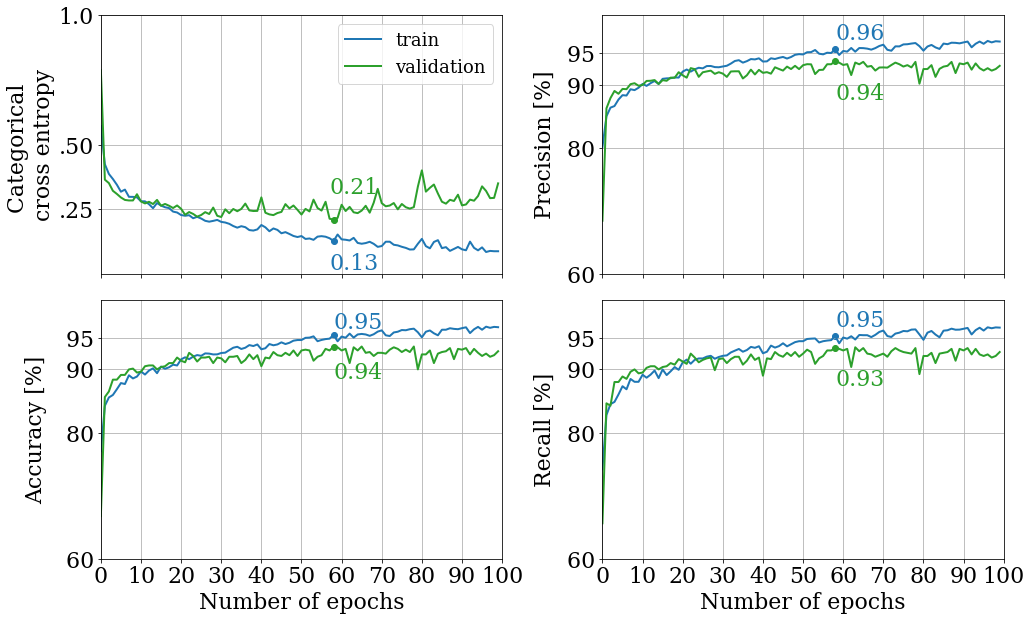

In [11]:
# MODEL 4
# Epoch 58 
# loss: 0.1990 - accuracy: 0.9367 - precision: 0.9377 - recall: 0.9367

fig, ax = plt.subplots(2,2);
index = 58
limit = len(loss_save)
ax[0,0].plot(loss_save,color='tab:blue',label='train');
ax[0,0].plot(Vloss_save,color='tab:green',label='validation');
ax[0,0].set_ylabel('Categorical \ncross entropy');
ax[0,0].grid();
ax[0,0].set_xlim(0,limit)
ax[0,0].set_xticks(np.arange(0,limit+1,10))
ax[0,0].legend(fontsize=fontsize1-4);ax[0,0].set_ylim(0,1.0)
ax[0,0].set_yticks([0.25,0.5,1.0]);ax[0,0].set_yticklabels(['.25','.50','1.0'])
ax[0,0].text(index-1,loss_save[index]-0.11,s=str(round(loss_save[index],2)),color='tab:blue')
ax[0,0].scatter(index,loss_save[index],color='tab:blue')
ax[0,0].text(index-1,Vloss_save[index]+0.10,s=str(round(Vloss_save[index],2)),color='tab:green')
ax[0,0].scatter(index,Vloss_save[index],color='tab:green')

ax[1,0].plot(accuracy_save,color='tab:blue',label='train')
ax[1,0].plot(Vaccuracy_save,color='tab:green',label='validation');
ax[1,0].set_ylabel('Accuracy [%]');
ax[1,0].set_xlim(0,limit);ax[1,0].set_ylim(0.6,1.01)
ax[1,0].set_xticks(np.arange(0,limit+1,10))
ax[1,0].grid();
ax[1,0].set_yticks([0.6,0.8,0.9,0.95]);ax[1,0].set_yticklabels(['  60','  80','  90','  95'])
ax[1,0].text(index,accuracy_save[index]+0.01,s=str(round(accuracy_save[index],2)),color='tab:blue')
ax[1,0].scatter(index,accuracy_save[index],color='tab:blue')
ax[1,0].text(index,Vaccuracy_save[index]-0.05,s=str(round(Vaccuracy_save[index],2)),color='tab:green')
ax[1,0].scatter(index,Vaccuracy_save[index],color='tab:green')
ax[1,0].set_xlabel('Number of epochs');

ax[0,1].plot(precision,color='tab:blue')
ax[0,1].plot(Vprecision,color='tab:green');
ax[0,1].set_ylabel('Precision [%]');
ax[0,1].set_xlim(0,limit);ax[0,1].set_ylim(0.6,1.01)
ax[0,1].set_xticks(np.arange(0,limit+1,10))
ax[0,1].grid();
ax[0,1].set_yticks([0.6,0.8,0.9,0.95]);ax[0,1].set_yticklabels([' 60',' 80',' 90',' 95'])
ax[0,1].scatter(index,precision[index],color='tab:blue')
ax[0,1].text(index,precision[index]+0.015,s=str(round(precision[index],2)),color='tab:blue')
ax[0,1].scatter(index,Vprecision[index],color='tab:green')
ax[0,1].text(index,Vprecision[index]-0.06,s=str(round(Vprecision[index],2)),color='tab:green')

ax[1,1].plot(recall,color='tab:blue',label='recall train')
ax[1,1].plot(Vrecall,color='tab:green',label='recall val.');
ax[1,1].set_ylabel('Recall [%]');
ax[1,1].set_xlabel('Number of epochs');
ax[1,1].set_xlim(0,limit);ax[1,1].set_ylim(0.6,1.01)
ax[1,1].set_xticks(np.arange(0,limit+1,10))
ax[1,1].grid();

ax[1,1].set_yticks([0.6,0.8,0.9,0.95]);ax[1,1].set_yticklabels([' 60',' 80',' 90',' 95'])
ax[1,1].scatter(index,recall[index],color='tab:blue')
ax[1,1].text(index,recall[index]+0.015,s=str(round(recall[index],2)),color='tab:blue')
ax[1,1].scatter(index,Vrecall[index],color='tab:green')
ax[1,1].text(index,Vrecall[index]-0.06,s=str(round(Vrecall[index],2)),color='tab:green')

plt.setp(ax[0,0].get_xticklabels(), visible=False);
plt.setp(ax[0,1].get_xticklabels(), visible=False);

plt.savefig(pathSave+'class/'+str(args.model_number)+'_fig1', bbox_inches='tight') 

# Dataset

In [11]:
import matlab.engine
import matplotlib
import matplotlib.pyplot as plt
from PlotInteractiveFunctions import cmap_map
eng = matlab.engine.start_matlab()
eng.addpath(os.getcwd()+'/MatlabFunctions/',nargout=0)

In [12]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.constants import golden 
matplotlib.rcParams['figure.figsize'] = (golden * 10, 10)
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fontsize1 = 32
matplotlib.rcParams.update({'font.size': fontsize1})
light_jet = cmap_map(lambda x: x + 0.2, matplotlib.cm.jet)

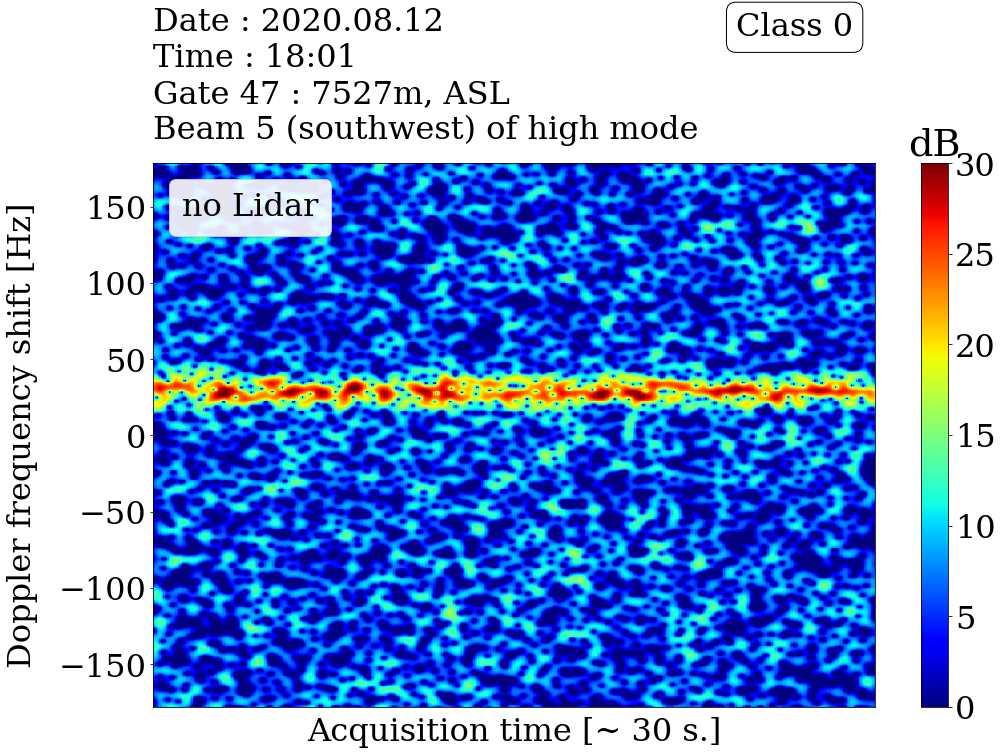

In [15]:
# Train
for indice, k in enumerate(train_list[0:3600]+train_list[4400:6800]):
    out = eng.loadSpecOnly(k[3],k[2],k[0]+1, nargout=4)
    
    if k[4] >= 0:
        spec =  np.array(out[0])
    if k[4] < 0:
        spec = np.flip(np.array(out[0]),axis=0)
        k[4]=k[4]*-1;k[5]=k[5]*-1 #reverse llabel and velocity
        
    fig, ax = plt.subplots();
    date = re.search(path_dat+'(.*).dat',k[3]).group(1).split('.DAT/')  
    
    ax.annotate('Date : '+titleChosenDate(date[0]) + ' \nTime : '+k[1][0:2]+':'+k[1][2:4]+
                 '\nGate '+ str(k[0])+ ' : ' + str(high_mode[k[0]]) + 'm, ASL'+
                 '\n'+ beam_radar_pretty[str(k[2])],
                xy=(0, 700), xycoords='axes points', 
                size=fontsize1, ha='left', va='top')
    
    ax.annotate('Class '+str(int(k[4])),
            xy=(700, 695), xycoords='axes points', 
            size=fontsize1, ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))
          
    im1=ax.pcolormesh(np.arange(0,544,1),np.array(out[1]),spec ,cmap='jet', vmin=0, vmax=30);
    if not np.isnan(k[5]):
        ax.axhline(k[5], color='black',linestyle='dashed',linewidth=5, label='Lidar')
        ax.legend(loc='upper left',framealpha=0.9)
    if np.isnan(k[5]):
        ax.axhline(k[5], color='black',linestyle='dashed',linewidth=5, label='no Lidar')
        leg = ax.legend(loc='upper left',handlelength=0,handletextpad=0,framealpha=0.9)
        for item in leg.legendHandles: item.set_visible(False)    
 
    cbar1 = fig.colorbar(im1)
    cbar1.ax.set_title('dB')
    ax.set_ylabel('Doppler frequency shift [Hz]')
    ax.set_xlabel('Acquisition time [~ 30 s.]')
    plt.setp(ax.get_xticklabels(), visible=False);
    ax.tick_params(axis='x', which='both',bottom=False, top=False)
    ax.yaxis.labelpad=20
    ax.xaxis.labelpad=10

    plt.savefig(pathSave+'class/train/train'+str(indice), bbox_inches='tight')
    plt.close()
    print(indice)

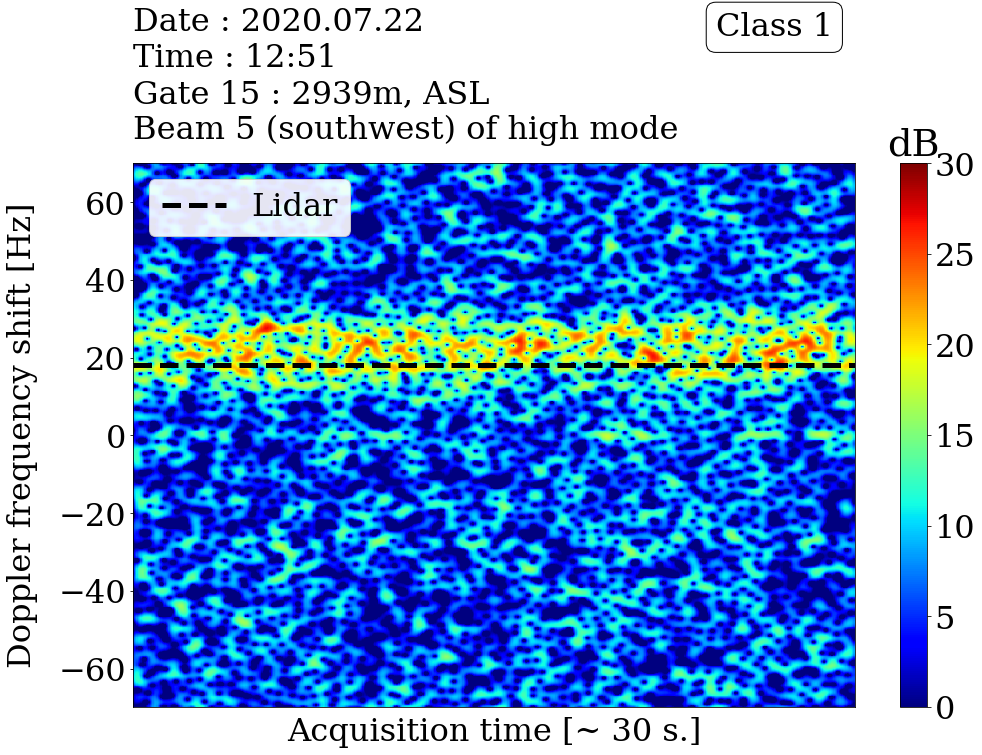

In [19]:
# Validation

for indice, k in enumerate(train_list[3600:4401]): 
    out = eng.loadSpecOnly(k[3],k[2],k[0]+1, nargout=4)

    if k[4] >= 0:
        spec =  np.array(out[0])
    if k[4] < 0:
        spec = np.flip(np.array(out[0]),axis=0)
        k[4]=k[4]*-1;k[5]=k[5]*-1

    fig, ax = plt.subplots();
    date = re.search(path_dat+'(.*).dat',k[3]).group(1).split('.DAT/')  

    ax.annotate('Date : '+titleChosenDate(date[0]) + ' \nTime : '+k[1][0:2]+':'+k[1][2:4]+
                 '\nGate '+ str(k[0])+ ' : ' + str(high_mode[k[0]]) + 'm, ASL'+
                 '\n'+ beam_radar_pretty[str(k[2])],
                xy=(0, 700), xycoords='axes points', 
                size=fontsize1, ha='left', va='top')

    ax.annotate('Class '+str(int(k[4])),
            xy=(700, 695), xycoords='axes points', 
            size=fontsize1, ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))

    im1=ax.pcolormesh(np.arange(0,544,1),np.array(out[1]),spec ,cmap='jet', vmin=0, vmax=30);
    if not np.isnan(k[5]):
        ax.axhline(k[5], color='black',linestyle='dashed',linewidth=5, label='Lidar')
        ax.legend(loc='upper left',framealpha=0.9)
    if np.isnan(k[5]):
        ax.axhline(k[5], color='black',linestyle='dashed',linewidth=5, label='no Lidar')
        leg = ax.legend(loc='upper left',handlelength=0,handletextpad=0,framealpha=0.9)
        for item in leg.legendHandles: item.set_visible(False)    

    cbar1 = fig.colorbar(im1)
    cbar1.ax.set_title('dB')
    ax.set_ylabel('Doppler frequency shift [Hz]')
    ax.set_xlabel('Acquisition time [~ 30 s.]')
    plt.setp(ax.get_xticklabels(), visible=False);
    ax.tick_params(axis='x', which='both',bottom=False, top=False)
    ax.yaxis.labelpad=20
    ax.xaxis.labelpad=10

    plt.savefig(pathSave+'class/val/val'+str(indice), bbox_inches='tight')
    plt.close()
    print(indice)

In [13]:
# Test

for indice, k in enumerate(test_list[0:900]):  
    out = eng.loadSpecOnly(k[3],k[2],k[0]+1, nargout=4)
    
    if k[4] >= 0:
        spec =  np.array(out[0])
    if k[4] < 0:
        spec = np.flip(np.array(out[0]),axis=0)
        k[4]=k[4]*-1;k[5]=k[5]*-1
        
    fig, ax = plt.subplots();
    date = re.search(path_dat+'(.*).dat',k[3]).group(1).split('.DAT/')  
    
    ax.annotate('Date : '+titleChosenDate(date[0]) + ' \nTime : '+k[1][0:2]+':'+k[1][2:4]+
                 '\nGate '+ str(k[0])+ ' : ' + str(high_mode[k[0]]) + 'm, ASL'+
                 '\n'+ beam_radar_pretty[str(k[2])],
                xy=(0, 700), xycoords='axes points', 
                size=fontsize1, ha='left', va='top')
    
    ax.annotate('Class '+str(int(k[4]))+
                '\nPredicted '+str(int(pred_class_test[indice])),
            xy=(700, 695), xycoords='axes points', 
            size=fontsize1, ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))
          
    im1=ax.pcolormesh(np.arange(0,544,1),np.array(out[1]),spec ,cmap='jet', vmin=0, vmax=30);
    if not np.isnan(k[5]):
        ax.axhline(k[5], color='black',linestyle='dashed',linewidth=5, label='Lidar')
        ax.legend(loc='upper left',framealpha=0.9)
    if np.isnan(k[5]):
        ax.axhline(k[5], color='black',linestyle='dashed',linewidth=5, label='no Lidar')
        leg = ax.legend(loc='upper left',handlelength=0,handletextpad=0,framealpha=0.9)
        for item in leg.legendHandles: item.set_visible(False)    
 
    cbar1 = fig.colorbar(im1)
    cbar1.ax.set_title('dB')
    ax.set_ylabel('Doppler frequency shift [Hz]')
    ax.set_xlabel('Acquisition time [~ 30 s.]')
    plt.setp(ax.get_xticklabels(), visible=False);
    ax.tick_params(axis='x', which='both',bottom=False, top=False)
    ax.yaxis.labelpad=20
    ax.xaxis.labelpad=10

        
    if k[4] != pred_class_test[indice]:
        plt.savefig(pathSave+'class/test/wrongly_classified/test'+str(indice), bbox_inches='tight')
    else:
        plt.savefig(pathSave+'class/test/well_classified/test'+str(indice), bbox_inches='tight')
               
    plt.close()    
    print(indice)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Histograms additional features

In [25]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.constants import golden 
matplotlib.rcParams['figure.figsize'] = (golden * 10, 10)
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fontsize1 = 22
matplotlib.rcParams.update({'font.size': fontsize1})
matplotlib.rcParams['figure.subplot.hspace'] = 0.32
import itertools

In [22]:
noise_train1 = np.array(list(itertools.chain(*noise_train[:36]+noise_train[44:-1])))
maxT_train1 = np.array(list(itertools.chain(*maxT_train[:36]+maxT_train[44:-1])))

noise_val1 = np.array(list(itertools.chain(*noise_train[36:44])))
maxT_val1 = np.array(list(itertools.chain(*maxT_train[36:44])))

noise_test1 = np.array(list(itertools.chain(*noise_test[:-1])))
maxT_test1 = np.array(list(itertools.chain(*maxT_test[:-1])))

labels_train = [int(k[4]) for k in train_list[0:3600]+train_list[4400:6800]]
labels_validation = [int(k[4]) for k in train_list[3600:4400]]
labels_test = [int(k[4]) for k in test_list[:900]]

In [23]:
def binned(variable,labels,binnb=40):
    hist,bins=np.histogram(variable,bins=binnb)
    logbins=np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    a=variable.copy(); b=variable.copy(); c=variable.copy(); d=variable.copy()
    a[np.array(labels)!=0]=np.nan; b[np.array(labels)!=1]=np.nan
    c[np.array(labels)!=2]=np.nan; d[np.array(labels)!=3]=np.nan
    x=np.vstack((a,b,c,d)).T
    
    return logbins,x

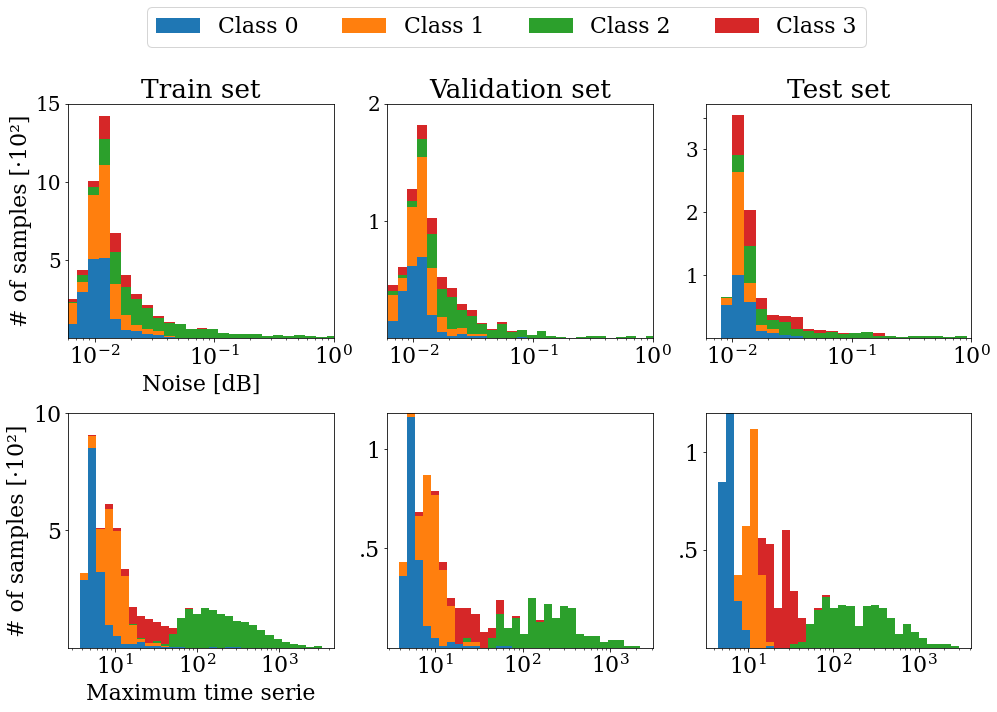

In [26]:
fig, ax = plt.subplots(2,3);

logbins,x = binned(noise_train1,labels=labels_train)
ax[0,0].hist(x, bins=logbins,stacked=True,label=['Class 0','Class 1','Class 2','Class 3']);ax[0,0].set_xscale('log')
ax[0,0].set_title('Train set');

ax[0,0].set_ylabel('# of samples [·10²]');
ax[0,0].set_xlabel('Noise [dB]');

logbins,x = binned(noise_val1,labels=labels_validation)
ax[0,1].hist(x, bins=logbins,stacked=True);ax[0,1].set_xscale('log')
ax[0,1].set_title('Validation set');

logbins,x = binned(noise_test1,labels=labels_test)
ax[0,2].hist(x, bins=logbins,stacked=True);ax[0,2].set_xscale('log')
ax[0,2].set_title('Test set');

ax[0,0].set_xlim(0.006,1);ax[0,1].set_xlim(0.006,1);ax[0,2].set_xlim(0.006,1);
ax[0,0].set_yticks([500,1000,1500]);ax[0,1].set_yticks([100,200]);ax[0,2].set_yticks([100,200,300,350]);
ax[0,0].set_yticklabels([5,10,15],fontsize=fontsize1-2);
ax[0,1].set_yticklabels([1,2],fontsize=fontsize1-2);
ax[0,2].set_yticklabels([1,2,3,''],fontsize=fontsize1-2);

logbins,x = binned(maxT_train1,labels=labels_train,binnb=30)
ax[1,0].hist(x, bins=logbins,stacked=True);ax[1,0].set_xscale('log')
ax[1,0].set_ylabel('# of samples [·10²]');
ax[1,0].set_xlabel('Maximum time serie');

logbins,x = binned(maxT_val1,labels=labels_validation,binnb=30)
ax[1,1].hist(x, bins=logbins,stacked=True);ax[1,1].set_xscale('log')

logbins,x = binned(maxT_test1,labels=labels_test,binnb=30)
ax[1,2].hist(x, bins=logbins,stacked=True);ax[1,2].set_xscale('log')

ax[1,0].set_yticks([500,1000]);ax[1,1].set_yticks([50,100]);ax[1,2].set_yticks([50,100]);
ax[1,0].set_yticklabels([5,10]);ax[1,1].set_yticklabels(['.5',1]);ax[1,2].set_yticklabels(['.5',1]);

ax[0,0].legend(ncol=4,loc='upper center',bbox_to_anchor=(1.1,0.73,1.1,0.73));
plt.savefig(pathSave+'class/'+'fig3', bbox_inches='tight')